# Evaluate planner

In [1]:
from __future__ import annotations

from pathlib import Path
from typing import TYPE_CHECKING

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML, display
import seaborn as sb
from shapely import Polygon
from tabulate import tabulate
from tilemapbase import Extent

from adaptive_planner.evaluation import EvaluationResult
from adaptive_planner.io.geojson import read_polygon_file
from adaptive_planner.io.kml import read_kml_file
from adaptive_planner.io.topcon import read_topcon_data
from adaptive_planner.location import Location
from adaptive_planner.utils import calculate_total_distance, parallel_execute, parallel_execute2
from adaptive_planner.visualisation import create_table, plot_confusion_matrix, plot_flight_path, save_fig

if TYPE_CHECKING:
    from numpy.typing import NDArray

%matplotlib inline

plt.rcParams["text.usetex"] = True

Define plot helper functions:

In [2]:
COLOR = "#c8586c"
BASELINE_COLOR = "#6699CC"

# Set data folder to different path when working inside devcontainer
if Path("/.devcontainer").is_dir():
    DATA_FOLDER = Path("/home/abe/data/")
else:
    DATA_FOLDER = Path("/media/rick/DATA_RICK/adaptive-planning")


def _hide_axes(ax: plt.Axes) -> None:
    ax.axis("off")


def _display_table(table_html: str) -> None:
    display(
        HTML(
            f"""
        <div style="max-height: 300px; overflow-y: auto; border: 1px solid #ccc;">
            {table_html}
        </div>
        """
        )
    )

Define the ground truth files:

In [3]:
GT_FILES = {
    "clustered_1": DATA_FOLDER / "20240213_clustered_1/plants_clustered_1_RDNAPTRANS2008.csv",
    "clustered_2": DATA_FOLDER / "20240423_clustered_2/plants_clustered_2_RDNAPTRANS2008.csv",
    "clustered_3": DATA_FOLDER / "20240718_clustered_3/plants_clustered_3_RDNAPTRANS2008.csv",
    "clustered_4": DATA_FOLDER / "20240801_clustered_4/plants_clustered_4_RDNAPTRANS2008.csv",
    "uniform_1": DATA_FOLDER / "20240213_uniform_1/plants_uniform_1_RDNAPTRANS2008.csv",
    "uniform_2": DATA_FOLDER / "20240423_uniform_2/plants_uniform_2_RDNAPTRANS2008.csv",
    "uniform_3": DATA_FOLDER / "20240718_uniform_3/plants_uniform_3_RDNAPTRANS2008.csv",
    "uniform_4": DATA_FOLDER / "20240801_uniform_4/plants_uniform_4_RDNAPTRANS2008.csv",
}

FIELD_FILES = {
    "clustered_1": Path("fields/clustered_1.geojson"),
    "clustered_2": Path("fields/clustered_2.geojson"),
    "clustered_3": Path("fields/clustered_3.geojson"),
    "clustered_4": Path("fields/clustered_4.geojson"),
    "uniform_1": Path("fields/uniform_1.geojson"),
    "uniform_2": Path("fields/uniform_2.geojson"),
    "uniform_3": Path("fields/uniform_3.geojson"),
    "uniform_4": Path("fields/uniform_4.geojson"),
}

CLUSTERED_DATASETS = ["clustered_1", "clustered_2", "clustered_3", "clustered_4"]
UNIFORM_DATASETS = ["uniform_1", "uniform_2", "uniform_3", "uniform_4"]

assert all([f.is_file() for f in GT_FILES.values()])
assert all([f.is_file() for f in FIELD_FILES.values()])
assert set(GT_FILES.keys()) == set(CLUSTERED_DATASETS + UNIFORM_DATASETS)

Load the ground truth data:

In [4]:
GT_LOCATIONS = parallel_execute(GT_FILES, read_topcon_data)

## Parameter optimization
Define the data files:

In [5]:
altitudes = [12, 24, 36, 48]
accept_thresholds = [0.4, 0.6, 0.8, 1.0]
reject_thresholds = [0.05, 0.2, 0.4]

data_folders: dict[str, Path] = {}
for altitude in altitudes:
    for accept_threshold in accept_thresholds:
        for reject_threshold in reject_thresholds:
            if accept_threshold == reject_threshold:
                continue

            for dataset in CLUSTERED_DATASETS + UNIFORM_DATASETS:
                key = f"accept_{accept_threshold}_reject_{reject_threshold}_{altitude}m_{dataset}"
                data_folders[key] = Path(
                    f"planner_evaluation_results/parameter_estimation/alt_{altitude}m_accept_{accept_threshold}_reject_{reject_threshold}_{dataset}"
                )


baseline_data_folders = {
    f"{alt}m_{ds}": Path(f"planner_evaluation_results/parameter_estimation/baseline_{alt}m_{ds}")
    for alt in altitudes
    for ds in CLUSTERED_DATASETS + UNIFORM_DATASETS
}

assert all(f.is_dir() for f in data_folders.values())
assert all(f.is_dir() for f in baseline_data_folders.values())

Load data:

In [6]:
dt_locations = parallel_execute({k: v / "detections.kml" for k, v in data_folders.items()}, read_kml_file)
baseline_dt_locations = parallel_execute({k: v / "detections.kml" for k, v in baseline_data_folders.items()}, read_kml_file)

flight_paths = parallel_execute({k: v / "flight_path.kml" for k, v in data_folders.items()}, read_kml_file)
baseline_flight_paths = parallel_execute({k: v / "flight_path.kml" for k, v in baseline_data_folders.items()}, read_kml_file)

Do evaluation:

In [13]:
dt_gt_locations = {dt_k: (gt_v, dt_v) for dt_k, dt_v in dt_locations.items() for gt_k, gt_v in GT_LOCATIONS.items() if gt_k in dt_k}
baseline_dt_gt_locations = {
    dt_k: (gt_v, dt_v) for dt_k, dt_v in baseline_dt_locations.items() for gt_k, gt_v in GT_LOCATIONS.items() if gt_k in dt_k
}

evaluation_results = parallel_execute2(
    dt_gt_locations, EvaluationResult.from_georeferenced_detections, conf_threshold=0.5, dist_threshold=0.35
)
baseline_evaluation_results = parallel_execute2(
    baseline_dt_gt_locations, EvaluationResult.from_georeferenced_detections, conf_threshold=0.5, dist_threshold=0.35
)

Calculate flight distances:

In [8]:
distances = parallel_execute(flight_paths, calculate_total_distance)
baseline_distances = parallel_execute(baseline_flight_paths, calculate_total_distance)

### Parameter estimation table
Create functions to gather data and create the table:

In [9]:
def gather_table_f1_data(
    dataset_names: list[str], evaluations: dict[str, EvaluationResult], baseline_evaluations: dict[str, EvaluationResult]
) -> NDArray[np.float32]:
    data = np.zeros((len(altitudes), len(accept_thresholds) * len(reject_thresholds) + 1))

    for i, alt in enumerate(altitudes):
        f1_scores = []
        for dataset in dataset_names:
            f1_scores.append(baseline_evaluations[f"{alt}m_{dataset}"].f1)

        data[i, 0] = np.mean(f1_scores)

    for i, alt in enumerate(altitudes):
        for j, reject_threshold in enumerate(reject_thresholds):
            for k, accept_threshold in enumerate(accept_thresholds):
                if reject_threshold == accept_threshold:
                    continue

                f1_scores = []
                for dataset in dataset_names:
                    key = f"accept_{accept_threshold}_reject_{reject_threshold}_{alt}m_{dataset}"
                    f1_scores.append(evaluations[key].f1)

                data[i, k * len(reject_thresholds) + j + 1] = np.mean(f1_scores)

    return data


def gather_table_distance_data(
    dataset_names: list[str], distances: dict[str, float], baseline_distances: dict[str, float]
) -> NDArray[np.float32]:
    data = np.zeros((len(altitudes), len(accept_thresholds) * len(reject_thresholds) + 1))

    for i, alt in enumerate(altitudes):
        _distances = []
        for dataset in dataset_names:
            _distances.append(baseline_distances[f"{alt}m_{dataset}"] / baseline_distances[f"12m_{dataset}"])

        data[i, 0] = np.mean(_distances)

    for i, alt in enumerate(altitudes):
        for j, reject_threshold in enumerate(reject_thresholds):
            for k, accept_threshold in enumerate(accept_thresholds):
                if reject_threshold == accept_threshold:
                    continue

                _distances = []
                for dataset in dataset_names:
                    key = f"accept_{accept_threshold}_reject_{reject_threshold}_{alt}m_{dataset}"
                    _distances.append(distances[key] / baseline_distances[f"12m_{dataset}"])

                data[i, k * len(reject_thresholds) + j + 1] = np.mean(_distances)

    return data


def create_heatmap(
    data: NDArray[np.float32],
    ax: plt.Axes,
    label: str = "F1-score",
    vmin: float = 0.1,
    vmax: float = 0.9,
    cbar_ticks: list[float] = [0.1, 0.5, 0.9],
    cmap: str = "plasma",
) -> None:
    data[data == 0] = np.nan

    # Skip empty column
    data = np.delete(data, 3, axis=1)
    data = np.insert(data, 1, [np.nan, np.nan, np.nan, np.nan], axis=1)

    x1_labels = ["", "", "0.05", "0.2", "0.05", "0.2", "0.4", "0.05", "0.2", "0.4", "0.05", "0.2", "0.4"]
    x2_labels = [f"{accept_threshold}" for accept_threshold in accept_thresholds]

    heatmap = sb.heatmap(
        data,
        annot=False,
        square=True,
        ax=ax,
        cmap=cmap,
        cbar_kws={"label": label, "panchor": (0.0, 0.0)},
        fmt=".0f",
        vmin=vmin,
        vmax=vmax,
    )

    colorbar = heatmap.collections[0].colorbar
    colorbar.set_ticks(cbar_ticks)

    ax.set_ylabel("Coverage altitude")
    ax.set_yticklabels([f"{alt}m" for alt in altitudes], rotation=0)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_xlabel("Rejection confidence threshold", x=0.58)
    ax.set_xticklabels(x1_labels, rotation=90)

    ax.xaxis.get_major_ticks()[0].set_visible(False)  # Remove tick for baseline
    ax.xaxis.get_major_ticks()[1].set_visible(False)  # Remove tick for baseline

    ax2 = fig.add_axes((0.220, 0.42, 0.48 if len(str(cbar_ticks[0]).split(".")[1]) > 1 else 0.49, 0.0))
    ax2.spines["bottom"].set_color("#ffffff")
    ax2.spines["top"].set_color("#ffffff")
    ax2.yaxis.set_visible(False)
    ax2.set_xticks([1.7, 3.9, 6.6, 9.2])
    ax2.set_xticklabels(x2_labels)
    ax2.set_xlabel("Acceptance confidence threshold", x=0.60)

    # Add vertical lines inside plot
    ax.plot([4, 4], [0.05, 3.95], color="black", linewidth=2)[0].set_clip_on(False)
    ax.plot([7, 7], [0.05, 3.95], color="black", linewidth=2)[0].set_clip_on(False)
    ax.plot([10, 10], [0.05, 3.95], color="black", linewidth=2)[0].set_clip_on(False)

    # Add horizontal lines to indicate the acceptance threshold range
    ax.plot([2.2, 3.8], [4.3, 4.3], color="black", linewidth=0.5)[0].set_clip_on(False)
    ax.plot([4.2, 6.8], [4.3, 4.3], color="black", linewidth=0.5)[0].set_clip_on(False)
    ax.plot([7.2, 9.8], [4.3, 4.3], color="black", linewidth=0.5)[0].set_clip_on(False)
    ax.plot([10.2, 12.8], [4.3, 4.3], color="black", linewidth=0.5)[0].set_clip_on(False)

    # Add lines to indicate the coverage planner and the adaptive planner
    ax.plot([-0.5, 1.4], [6.7, 6.7], color="black", linewidth=0.5)[0].set_clip_on(False)
    ax.plot([1.6, 13.5], [6.7, 6.7], color="black", linewidth=0.5)[0].set_clip_on(False)
    ax.plot([-0.5, -0.5], [6.7, 6.3], color="black", linewidth=0.5)[0].set_clip_on(False)
    ax.plot([1.45, 1.45], [6.7, 6.3], color="black", linewidth=0.5)[0].set_clip_on(False)
    ax.plot([1.55, 1.55], [6.7, 6.3], color="black", linewidth=0.5)[0].set_clip_on(False)
    ax.plot([13.5, 13.5], [6.7, 6.3], color="black", linewidth=0.5)[0].set_clip_on(False)
    ax.plot([0.5, 0.5], [6.7, 7.0], color="black", linewidth=0.5)[0].set_clip_on(False)
    ax.plot([7.0, 7.0], [6.7, 7.0], color="black", linewidth=0.5)[0].set_clip_on(False)

    ax.text(0.5, 7.3, "Coverage\nplanner", ha="center", va="top").set_clip_on(False)
    ax.text(7.0, 7.3, "Adaptive planner", ha="center", va="top").set_clip_on(False)

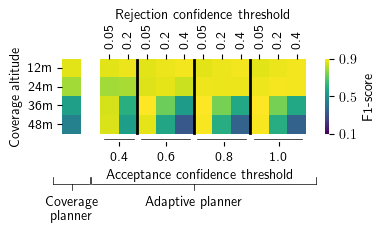

In [10]:
clustered_data = gather_table_f1_data(CLUSTERED_DATASETS, evaluation_results, baseline_evaluation_results)

fig, ax = plt.subplots(figsize=(4, 2.5))
create_heatmap(clustered_data, ax, label="F1-score", cmap="viridis", cbar_ticks=[0.1, 0.5, 0.9], vmin=0.1, vmax=0.9)

fig.tight_layout()
fig.subplots_adjust(top=0.75, bottom=0.45)
save_fig("figures/parameter_estimation/parameter_estimation_f1_table_clustered.pdf", fig, format="pdf", dpi=600)
fig.show()

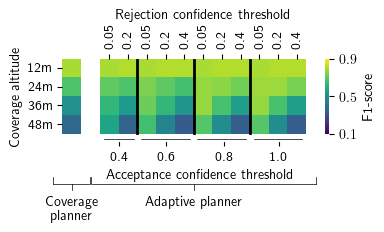

In [11]:
uniform_data = gather_table_f1_data(UNIFORM_DATASETS, evaluation_results, baseline_evaluation_results)

fig, ax = plt.subplots(figsize=(4, 2.5))
create_heatmap(uniform_data, ax, label="F1-score", cmap="viridis", cbar_ticks=[0.1, 0.5, 0.9], vmin=0.1, vmax=0.9)

fig.tight_layout()
fig.subplots_adjust(top=0.75, bottom=0.45)
save_fig("figures/parameter_estimation/parameter_estimation_f1_table_uniform.pdf", fig, format="pdf", dpi=600)
fig.show()

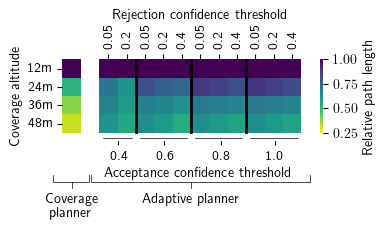

In [12]:
clustered_data = gather_table_distance_data(CLUSTERED_DATASETS, distances, baseline_distances)

fig, ax = plt.subplots(figsize=(4, 2.45))
create_heatmap(clustered_data, ax, label="Relative path length", cmap="viridis_r", cbar_ticks=[0.25, 0.50, 0.75, 1.0], vmin=0.25, vmax=1.0)

fig.tight_layout()
fig.subplots_adjust(top=0.75, bottom=0.45)
save_fig("figures/parameter_estimation/parameter_estimation_distance_table_clustered.pdf", fig, format="pdf", dpi=600)
fig.show()

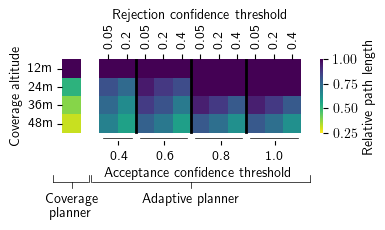

In [373]:
uniform_data = gather_table_distance_data(UNIFORM_DATASETS, distances, baseline_distances)

fig, ax = plt.subplots(figsize=(4, 2.45))
create_heatmap(uniform_data, ax, label="Relative path length", cmap="viridis_r", cbar_ticks=[0.25, 0.50, 0.75, 1.0], vmin=0.25, vmax=1.0)

fig.tight_layout()
fig.subplots_adjust(top=0.75, bottom=0.45)
save_fig("figures/parameter_estimation/parameter_estimation_distance_table_uniform.pdf", fig, format="pdf", dpi=600)
fig.show()

Define best working parameters:

In [7]:
CLUSTERED_BEST_ALTITUDE = 48
CLUSTERED_BEST_ACCEPT_CONF = 0.6
CLUSTERED_BEST_REJECT_CONF = 0.05

UNIFORM_BEST_ALTITUDE = 36
UNIFORM_BEST_ACCEPT_CONF = 0.8
UNIFORM_BEST_REJECT_CONF = 0.05

Details of best working parameters:

In [11]:
def get_evaluations(
    dataset_names: list[str], evaluations: dict[str, EvaluationResult], altitude: int, accept_conf: float | None, reject_conf: float | None
) -> list[EvaluationResult]:
    if accept_conf is None and reject_conf is None:
        return [evaluations[f"{altitude}m_{ds}"] for ds in dataset_names]
    return [evaluations[f"accept_{accept_conf}_reject_{reject_conf}_{altitude}m_{ds}"] for ds in dataset_names]


def get_distances(
    dataset_names: list[str], distances: dict[str, float], altitude: int, accept_conf: float | None, reject_conf: float | None
) -> NDArray[np.float32]:
    if accept_conf is None and reject_conf is None:
        return np.array([distances[f"{altitude}m_{ds}"] for ds in dataset_names], dtype=np.float32)
    return np.array([distances[f"accept_{accept_conf}_reject_{reject_conf}_{altitude}m_{ds}"] for ds in dataset_names], dtype=np.float32)


adaptive_evaluations_clustered = get_evaluations(
    CLUSTERED_DATASETS, evaluation_results, CLUSTERED_BEST_ALTITUDE, CLUSTERED_BEST_ACCEPT_CONF, CLUSTERED_BEST_REJECT_CONF
)
baseline_evaluations_clustered = get_evaluations(CLUSTERED_DATASETS, baseline_evaluation_results, CLUSTERED_BEST_ALTITUDE, None, None)
baseline_12m_evaluations_clustered = get_evaluations(CLUSTERED_DATASETS, baseline_evaluation_results, 12, None, None)

adaptive_evaluations_uniform = get_evaluations(
    UNIFORM_DATASETS, evaluation_results, UNIFORM_BEST_ALTITUDE, UNIFORM_BEST_ACCEPT_CONF, UNIFORM_BEST_REJECT_CONF
)
baseline_evaluations_uniform = get_evaluations(UNIFORM_DATASETS, baseline_evaluation_results, UNIFORM_BEST_ALTITUDE, None, None)
baseline_12m_evaluations_uniform = get_evaluations(UNIFORM_DATASETS, baseline_evaluation_results, 12, None, None)

adaptive_distances_clustered = get_distances(
    CLUSTERED_DATASETS, distances, CLUSTERED_BEST_ALTITUDE, CLUSTERED_BEST_ACCEPT_CONF, CLUSTERED_BEST_REJECT_CONF
)
baseline_distances_clustered = get_distances(CLUSTERED_DATASETS, baseline_distances, CLUSTERED_BEST_ALTITUDE, None, None)
baseline_12m_distances_clustered = get_distances(CLUSTERED_DATASETS, baseline_distances, 12, None, None)

adaptive_distances_uniform = get_distances(
    UNIFORM_DATASETS, distances, UNIFORM_BEST_ALTITUDE, UNIFORM_BEST_ACCEPT_CONF, UNIFORM_BEST_REJECT_CONF
)
baseline_distances_uniform = get_distances(UNIFORM_DATASETS, baseline_distances, UNIFORM_BEST_ALTITUDE, None, None)
baseline_12m_distances_uniform = get_distances(UNIFORM_DATASETS, baseline_distances, 12, None, None)

# Normalize flight path to the baseline 12m path (to compensate for the difference in area they cover)
adaptive_distances_clustered /= baseline_12m_distances_clustered
baseline_distances_clustered /= baseline_12m_distances_clustered

adaptive_distances_uniform /= baseline_12m_distances_uniform
baseline_distances_uniform /= baseline_12m_distances_uniform


def _mean_std(values: list[float]) -> str:
    return f"{np.mean(values):.3f}±{np.std(values):.3f}"


def _mean_std_attr(evaluation_results: list[EvaluationResult], attr: str) -> str:
    values = [getattr(eval_result, attr) for eval_result in evaluation_results]
    return _mean_std(values)


rows = [
    [
        "F1",
        _mean_std_attr(adaptive_evaluations_clustered, "f1"),
        _mean_std_attr(baseline_evaluations_clustered, "f1"),
        _mean_std_attr(baseline_12m_evaluations_clustered, "f1"),
        _mean_std_attr(adaptive_evaluations_uniform, "f1"),
        _mean_std_attr(baseline_evaluations_uniform, "f1"),
        _mean_std_attr(baseline_12m_evaluations_uniform, "f1"),
    ],
    [
        "Precision",
        _mean_std_attr(adaptive_evaluations_clustered, "precision"),
        _mean_std_attr(baseline_evaluations_clustered, "precision"),
        _mean_std_attr(baseline_12m_evaluations_clustered, "precision"),
        _mean_std_attr(adaptive_evaluations_uniform, "precision"),
        _mean_std_attr(baseline_evaluations_uniform, "precision"),
        _mean_std_attr(baseline_12m_evaluations_uniform, "precision"),
    ],
    [
        "Recall",
        _mean_std_attr(adaptive_evaluations_clustered, "recall"),
        _mean_std_attr(baseline_evaluations_clustered, "recall"),
        _mean_std_attr(baseline_12m_evaluations_clustered, "recall"),
        _mean_std_attr(adaptive_evaluations_uniform, "recall"),
        _mean_std_attr(baseline_evaluations_uniform, "recall"),
        _mean_std_attr(baseline_12m_evaluations_uniform, "recall"),
    ],
    [
        "Normalized flight path[% of baseline]",
        _mean_std(adaptive_distances_clustered),
        _mean_std(baseline_distances_clustered),
        _mean_std([1.0]),
        _mean_std(adaptive_distances_uniform),
        _mean_std(baseline_distances_uniform),
        _mean_std([1.0]),
    ],
]

header = [
    "Attribute",
    "Adaptive planner\nclustered",
    f"Baseline {CLUSTERED_BEST_ALTITUDE}m\nclustered",
    "Baseline 12m\nclustered",
    "Adaptive planner\nuniform",
    f"Baseline {UNIFORM_BEST_ALTITUDE}m\nuniform",
    "Baseline 12m\nuniform",
]

_display_table(tabulate(rows, headers=header, tablefmt="html"))

Attribute,Adaptive planner clustered,Baseline 48m clustered,Baseline 12m clustered,Adaptive planner uniform,Baseline 36m uniform,Baseline 12m uniform
F1,0.867±0.024,0.119±0.019,0.891±0.021,0.784±0.075,0.302±0.155,0.807±0.039
Precision,0.891±0.035,0.380±0.102,0.890±0.034,0.823±0.052,0.574±0.067,0.834±0.041
Recall,0.846±0.032,0.073±0.016,0.893±0.013,0.750±0.097,0.221±0.141,0.782±0.039
Normalized flight path[% of baseline],0.631±0.035,0.312±0.042,1.000±0.000,0.938±0.116,0.386±0.061,1.000±0.000


### Flight paths

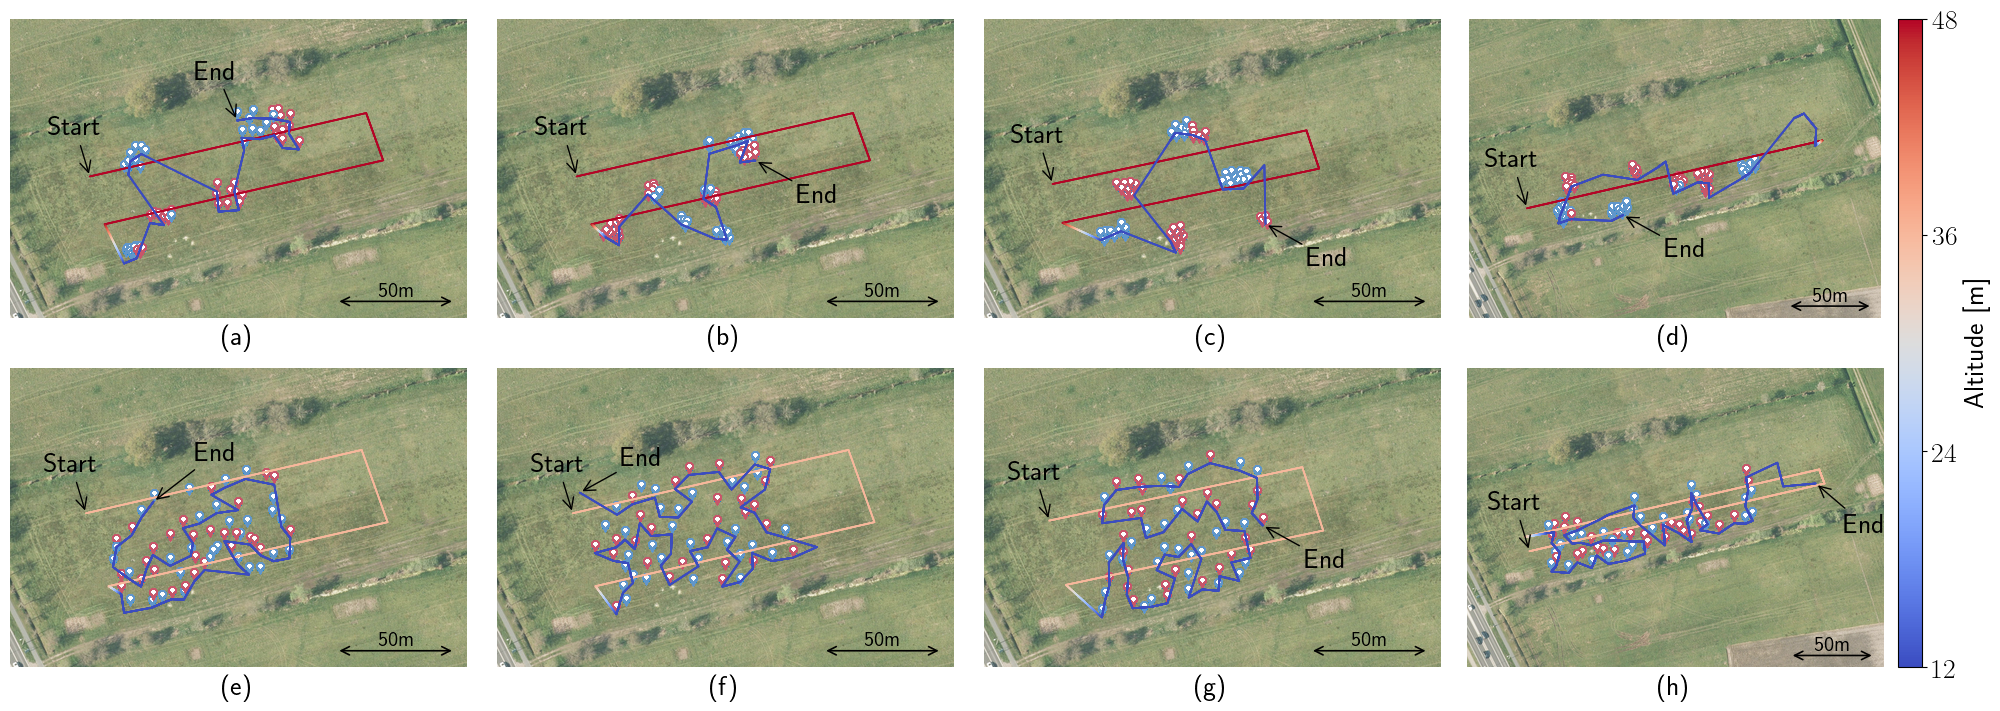

In [52]:
FONTSIZE = 20
CMAP = "coolwarm"
EXTENT = Extent.from_lonlat(5.666859863769067, 5.669665991011977, 51.99065765607528, 51.991790778538724)
CLASS_COLORS = {
    "F": (97, 150, 202),
    "W": (199, 86, 106),
}

markers = [
    [GT_LOCATIONS["clustered_1"], GT_LOCATIONS["clustered_2"], GT_LOCATIONS["clustered_3"], GT_LOCATIONS["clustered_4"]],
    [GT_LOCATIONS["uniform_1"], GT_LOCATIONS["uniform_2"], GT_LOCATIONS["uniform_3"], GT_LOCATIONS["uniform_4"]],
]

end_marker_offsets = [
    [[-30, 30], [30, -30], [30, -30], [30, -30]],
    [[30, 30], [30, 20], [30, -30], [20, -35]],
]


fig = plt.figure(layout="constrained", figsize=(20, 7))
gs = GridSpec(2, 5, width_ratios=[1, 1, 1, 0.90, 0.05], figure=fig)

for i, (clustered_dataset_name, uniform_dataset_name) in enumerate(zip(CLUSTERED_DATASETS, UNIFORM_DATASETS)):
    flight_path_clustered = flight_paths[
        f"accept_{CLUSTERED_BEST_ACCEPT_CONF}_reject_{CLUSTERED_BEST_REJECT_CONF}_{CLUSTERED_BEST_ALTITUDE}m_{clustered_dataset_name}"
    ]
    flight_path_uniform = flight_paths[
        f"accept_{UNIFORM_BEST_ACCEPT_CONF}_reject_{UNIFORM_BEST_REJECT_CONF}_{UNIFORM_BEST_ALTITUDE}m_{uniform_dataset_name}"
    ]

    for j, flight_path in enumerate((flight_path_clustered, flight_path_uniform)):
        ax = fig.add_subplot(gs[j, i])
        plot_flight_path(
            flight_path,
            markers=markers[j][i],
            ax=ax,
            marker_class_to_color=CLASS_COLORS,
            colorbar=False,
            fontsize=FONTSIZE,
            linewidth=1.2,
            scalebar_length=50.0,
            scalebar_args={"fontsize": FONTSIZE - 5, "lw": 1.2, "mutation_scale": 15},
            marker_args={"zorder": 1},
            start_annotation_offset=(-30, 30),
            end_annotation_offset=end_marker_offsets[j][i],
            min_altitude=12,
            max_altitude=48,
            cmap_name=CMAP,
            extent=EXTENT if i < 3 else None,  # Use custom extent for dataset of 1 August, as it has different shape
        )
        ax.text(0.5, -0.02, f"({chr(97 + j * 4 + i)})", fontsize=FONTSIZE, ha="center", va="top", transform=ax.transAxes)

        # Remove borders around image
        for spine in ax.spines.values():
            spine.set_visible(False)

cbar_ax = fig.add_subplot(gs[0:2, 4])
sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(vmin=12, vmax=48))
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[12, 24, 36, 48])
cbar.ax.tick_params(labelsize=FONTSIZE)
cbar.set_label("Altitude [m]", fontsize=FONTSIZE)

save_fig("figures/parameter_estimation/parameter_estimation_flight_path_combined.pdf", fig, format="pdf")
fig.show()

## Localization uncertainty
Load the data files:

In [60]:
altitudes = [12, 24, 36, 48]
levels = ["perfect", "good", "decent", "poor", "very_poor"]

data_folders = {
    f"{altitude}m_{dataset}_{level}": Path(f"planner_evaluation_results/localization_uncertainty/{altitude}m_{dataset}_{level}")
    for altitude in altitudes
    for level in levels
    for dataset in CLUSTERED_DATASETS + UNIFORM_DATASETS
}
baseline_data_folders = {
    f"{altitude}m_{dataset}_{level}": Path(f"planner_evaluation_results/localization_uncertainty/baseline_{altitude}m_{dataset}_{level}")
    for altitude in altitudes
    for level in levels
    for dataset in CLUSTERED_DATASETS + UNIFORM_DATASETS
}

assert all(f.is_dir() for f in data_folders.values())
assert all(f.is_dir() for f in baseline_data_folders.values())

Load data:

In [61]:
dt_locations = parallel_execute({k: v / "detections.kml" for k, v in data_folders.items()}, read_kml_file)
baseline_dt_locations = parallel_execute({k: v / "detections.kml" for k, v in baseline_data_folders.items()}, read_kml_file)

flight_paths = parallel_execute({k: v / "flight_path.kml" for k, v in data_folders.items()}, read_kml_file)
baseline_flight_paths = parallel_execute({k: v / "flight_path.kml" for k, v in baseline_data_folders.items()}, read_kml_file)

Do evaluation:

In [62]:
dt_gt_locations = {dt_k: (gt_v, dt_v) for dt_k, dt_v in dt_locations.items() for gt_k, gt_v in GT_LOCATIONS.items() if gt_k in dt_k}
baseline_dt_gt_locations = {
    dt_k: (gt_v, dt_v) for dt_k, dt_v in baseline_dt_locations.items() for gt_k, gt_v in GT_LOCATIONS.items() if gt_k in dt_k
}

evaluation_results = parallel_execute2(
    dt_gt_locations, EvaluationResult.from_georeferenced_detections, conf_threshold=0.5, dist_threshold=0.35
)
baseline_evaluation_results = parallel_execute2(
    baseline_dt_gt_locations, EvaluationResult.from_georeferenced_detections, conf_threshold=0.5, dist_threshold=0.35
)

### Bar plot
Define function to get data:

In [73]:
LEVEL_MAP = {lvl: lvl.replace("_", "\n") for lvl in levels}


def get_data(eval_results: list[EvaluationResult], dataset_names: list[str]) -> NDArray[np.float32]:
    values = []
    for alt in altitudes:
        for level in levels:
            f1_scores = []
            for dataset in dataset_names:
                f1_scores.append(eval_results[f"{alt}m_{dataset}_{level}"].f1)

            values.append(f1_scores)

    return np.array(values, dtype=np.float32)


def plot_f1_bars(values: NDArray[np.float32], baseline_values: NDArray[np.float32], ax: plt.Axes) -> None:
    x = np.array([0.5 + i * (len(levels) + 0.5) + j for i in range(len(altitudes)) for j in range(len(levels))])
    bar_width = 0.35

    ax.grid(axis="y")
    ax.set_axisbelow(True)
    ax.set_yticks(np.linspace(0.0, 1.0, 6))

    ax.bar(x - bar_width / 2, values.mean(axis=1), yerr=values.std(axis=1), width=bar_width, label="Adaptive planner", color=COLOR)
    ax.bar(
        x + bar_width / 2,
        baseline_values.mean(axis=1),
        yerr=baseline_values.std(axis=1),
        width=bar_width,
        label="Coverage planner",
        color=BASELINE_COLOR,
    )

    ax.set_xticks(x, [LEVEL_MAP[lvl] for lvl in levels] * len(altitudes), rotation=90)
    ax.set_ylabel("F1-score")
    ax.set_xlim(min(x) - bar_width - 0.1, max(x) + bar_width + 0.1)
    ax.set_ylim(0.0, 1.0)

    for i, alt in enumerate(altitudes):
        start_i = i * (len(x) // len(altitudes))
        end_i = (i + 1) * (len(x) // len(altitudes)) - 1

        ax.text((x[end_i] + x[start_i]) / 2, ax.get_ylim()[0] - 0.43, f"{alt}m", ha="center")
        ax.plot([x[start_i] - bar_width, x[end_i] + bar_width], [-0.35, -0.35], color="black", linewidth=1)[0].set_clip_on(False)

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45), ncol=2, fancybox=True)

Create plot:

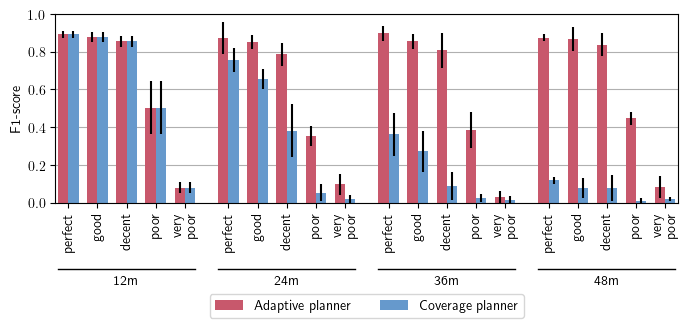

In [74]:
fig, ax = plt.subplots(figsize=(7, 3.2))
values = get_data(evaluation_results, CLUSTERED_DATASETS)
baseline_values = get_data(baseline_evaluation_results, CLUSTERED_DATASETS)
plot_f1_bars(values, baseline_values, ax)

fig.tight_layout(rect=(0, -0.11, 1, 1.03))
save_fig("figures/localization_uncertainty/localization_uncertainty_levels_f1_score_clustered.pdf", fig, format="pdf")
fig.show()

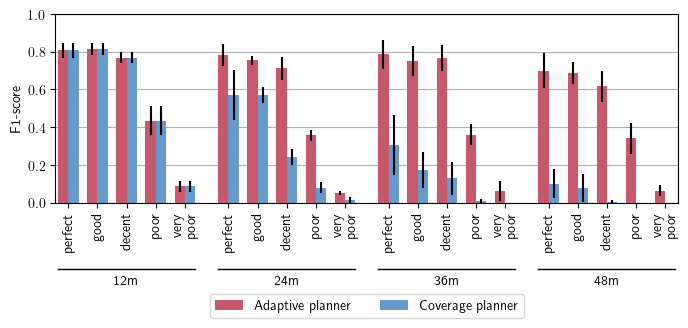

In [75]:
fig, ax = plt.subplots(figsize=(7, 3.2))
values = get_data(evaluation_results, UNIFORM_DATASETS)
baseline_values = get_data(baseline_evaluation_results, UNIFORM_DATASETS)
plot_f1_bars(values, baseline_values, ax)

fig.tight_layout(rect=(0, -0.11, 1, 1.03))
save_fig("figures/localization_uncertainty/localization_uncertainty_levels_f1_score_uniform.pdf", fig, format="pdf")
fig.show()

## Number of objects
Load the data files:

In [5]:
n_objects = list(range(0, 220, 20))

data_folders = {
    f"{n}_{dataset}": Path(f"planner_evaluation_results/number_of_objects/48m_{n}_{dataset}")
    for n in n_objects
    for dataset in CLUSTERED_DATASETS
}
data_folders.update(
    {
        f"{n}_{dataset}": Path(f"planner_evaluation_results/number_of_objects/36m_{n}_{dataset}")
        for n in n_objects
        for dataset in UNIFORM_DATASETS
    }
)
baseline_data_folders = {
    f"{n}_{dataset}": Path(f"planner_evaluation_results/number_of_objects/baseline_12m_{n}_{dataset}")
    for n in n_objects
    for dataset in CLUSTERED_DATASETS + UNIFORM_DATASETS
}

# Load the GT files that include the pasted objects
gt_files = {ds: Path(f"experiments/number_of_objects/{ds}_object_locations.kmz") for ds in CLUSTERED_DATASETS + UNIFORM_DATASETS}

# Calculate the area per dataset
areas = {
    name: Polygon(
        [Location(np.array([c[1], c[0]], dtype=np.float64)).utm_coordinate for c in read_polygon_file(boundary_file).exterior.coords]
    ).area
    for name, boundary_file in FIELD_FILES.items()
}

assert all([f.is_file() for f in gt_files.values()])
assert all(f.is_dir() for f in data_folders.values())
assert all(f.is_dir() for f in baseline_data_folders.values())

Load the ground truth:

In [6]:
gt_locations_all = parallel_execute(gt_files, read_kml_file)
gt_locations = {f"{n}_{ds}": gt_ds_all[:n] for n in n_objects for ds, gt_ds_all in gt_locations_all.items()}

Load data:

In [7]:
dt_locations = parallel_execute({k: v / "detections.kml" for k, v in data_folders.items()}, read_kml_file)
baseline_dt_locations = parallel_execute({k: v / "detections.kml" for k, v in baseline_data_folders.items()}, read_kml_file)

flight_paths = parallel_execute({k: v / "flight_path.kml" for k, v in data_folders.items()}, read_kml_file)
baseline_flight_paths = parallel_execute({k: v / "flight_path.kml" for k, v in baseline_data_folders.items()}, read_kml_file)

Do evaluation:

In [8]:
dt_gt_locations = {dt_k: (gt_locations[dt_k], dt_v) for dt_k, dt_v in dt_locations.items()}
baseline_dt_gt_locations = {dt_k: (gt_locations[dt_k], dt_v) for dt_k, dt_v in baseline_dt_locations.items()}

evaluation_results = parallel_execute2(
    dt_gt_locations, EvaluationResult.from_georeferenced_detections, conf_threshold=0.5, dist_threshold=0.35
)
baseline_evaluation_results = parallel_execute2(
    baseline_dt_gt_locations, EvaluationResult.from_georeferenced_detections, conf_threshold=0.5, dist_threshold=0.35
)

Calculate flight path length:

In [9]:
flight_path_length = parallel_execute(flight_paths, calculate_total_distance)
baseline_flight_path_length = parallel_execute(baseline_flight_paths, calculate_total_distance)

Gather figure data:

In [10]:
def gather_data(
    flight_path_length: dict[str, float],
    baseline_flight_path_length: dict[str, float],
    dataset_names: list[str],
) -> tuple[list[float], list[float]]:
    x, y = [], []
    for dataset_name in dataset_names:
        for n in n_objects:
            x.append(n / (areas[dataset_name] / 1e4))
            y.append(flight_path_length[f"{n}_{dataset_name}"] / baseline_flight_path_length[f"{n}_{dataset_name}"])
    return x, y


clustered_data = gather_data(flight_path_length, baseline_flight_path_length, CLUSTERED_DATASETS)
uniform_data = gather_data(flight_path_length, baseline_flight_path_length, UNIFORM_DATASETS)

Create figure:

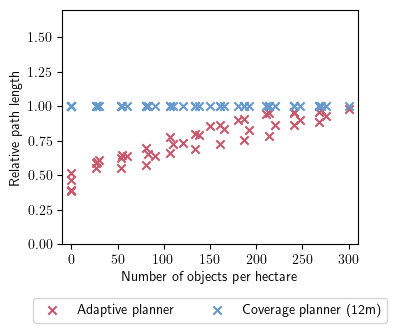

In [11]:
fig, ax = plt.subplots(figsize=(4, 3.2))

ax.scatter(clustered_data[0], clustered_data[1], c=COLOR, label="Adaptive planner", marker="x")
ax.scatter(clustered_data[0], np.repeat(1.0, len(clustered_data[0])), c=BASELINE_COLOR, label="Coverage planner (12m)", marker="x")
ax.set_xlabel("Number of objects per hectare")
ax.set_ylabel("Relative path length")
ax.set_xlim(-10, 310)
ax.set_ylim(0.0, 1.7)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), fancybox=True, ncol=2)

fig.tight_layout(rect=(0, -0.05, 1, 1.03))
save_fig("figures/number_of_objects/number_of_objects_clustered.pdf", fig, format="pdf", pad_inches=0)
fig.show()

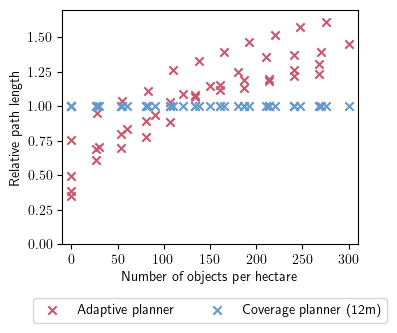

In [12]:
fig, ax = plt.subplots(figsize=(4, 3.2))

ax.scatter(uniform_data[0], uniform_data[1], c=COLOR, label="Adaptive planner", marker="x")
ax.scatter(clustered_data[0], np.repeat(1.0, len(clustered_data[0])), c=BASELINE_COLOR, label="Coverage planner (12m)", marker="x")

ax.set_xlabel("Number of objects per hectare")
ax.set_ylabel("Relative path length")
ax.set_xlim(-10, 310)
ax.set_ylim(0.0, 1.7)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), fancybox=True, ncol=2)

fig.tight_layout(rect=(0, -0.05, 1, 1.03))
save_fig("figures/number_of_objects/number_of_objects_uniform.pdf", fig, format="pdf", pad_inches=0)
fig.show()

Flight path plot:

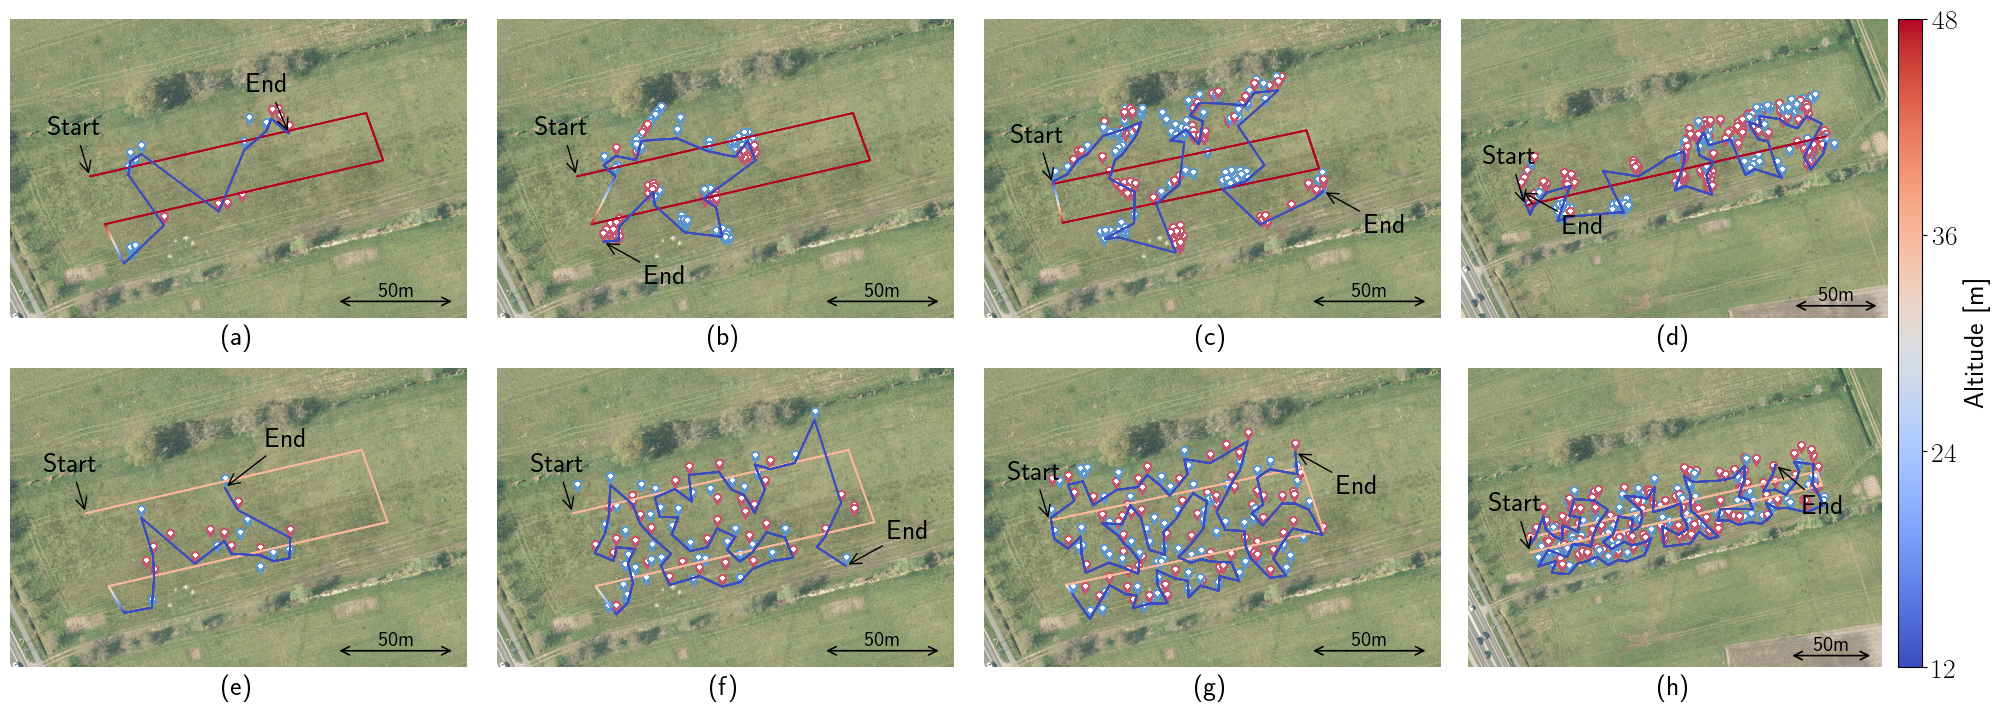

In [59]:
FONTSIZE = 20
CMAP = "coolwarm"
EXTENT = Extent.from_lonlat(5.666859863769067, 5.669665991011977, 51.99065765607528, 51.991790778538724)
CLASS_COLORS = {
    "F": (97, 150, 202),
    "W": (199, 86, 106),
}

number_of_objects = [[20, 80, 140, 200], [20, 80, 140, 200]]

end_marker_offsets = [
    [[-30, 30], [30, -30], [30, -30], [30, -30]],
    [[30, 30], [30, 20], [30, -30], [20, -35]],
]

fig = plt.figure(layout="constrained", figsize=(20, 7))
gs = GridSpec(2, 5, width_ratios=[1, 1, 1, 0.90, 0.05], figure=fig)

for i, (clustered_dataset_name, uniform_dataset_name) in enumerate(zip(CLUSTERED_DATASETS, UNIFORM_DATASETS)):
    for j, dataset_name in enumerate((clustered_dataset_name, uniform_dataset_name)):
        ax = fig.add_subplot(gs[j, i])
        plot_flight_path(
            flight_paths[f"{number_of_objects[j][i]}_{dataset_name}"],
            markers=gt_locations[f"{number_of_objects[j][i]}_{dataset_name}"],
            ax=ax,
            marker_class_to_color=CLASS_COLORS,
            colorbar=False,
            fontsize=FONTSIZE,
            linewidth=1.2,
            scalebar_length=50.0,
            scalebar_args={"fontsize": FONTSIZE - 5, "lw": 1.2, "mutation_scale": 15},
            marker_args={"zorder": 1},
            start_annotation_offset=(-30, 30),
            end_annotation_offset=end_marker_offsets[j][i],
            min_altitude=12,
            max_altitude=48,
            cmap_name=CMAP,
            extent=EXTENT if i < 3 else None,  # Use custom extent for dataset of 1 August, as it has different shape
        )
        ax.text(0.5, -0.02, f"({chr(97 + j * 4 + i)})", fontsize=FONTSIZE, ha="center", va="top", transform=ax.transAxes)

        # Remove borders around image
        for spine in ax.spines.values():
            spine.set_visible(False)

cbar_ax = fig.add_subplot(gs[0:2, 4])
sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(vmin=12, vmax=48))
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[12, 24, 36, 48])
cbar.ax.tick_params(labelsize=FONTSIZE)
cbar.set_label("Altitude [m]", fontsize=FONTSIZE)

save_fig("figures/number_of_objects/number_of_objects_flight_path_combined.pdf", fig, format="pdf", pad_inches=0)
fig.show()